# Figure 3: Single Changepoint, varying length or rate change

This requires Python 3, Julia v0.6 and R, including the specified Python and R libraries, as well as the change point source file for Julia. Imporantly, it also requires Jupyter notebook kernels for R and Julia be installed.

## Python 3 Kernel - Simulate Trajectories

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import beadpy
import pandas as pd
import itertools

Set a random seed for reproducible results:

In [2]:
random.seed(53)
np.random.seed(53)

In [3]:
%matplotlib inline

In [4]:
def single_cpt_fastversion(event_duration,
             rate_1,
              rate_2,
              noise_sigma,
              ntraj):
    rate_sequence = [rate_1]*int(event_duration/2)
    rate_sequence = rate_sequence + [rate_2]*int(event_duration/2)
    position = np.cumsum(rate_sequence)
    position  = np.tile(position, ntraj)
    position_withnoise = np.array(position) + np.random.normal(loc=0, scale = noise_sigma, size = event_duration*ntraj)
    time = np.tile(range(0, event_duration), ntraj)
    trajseq = np.repeat(range(0,ntraj), event_duration)
    results = pd.DataFrame({'time' : time,
                        'nucleotides' : position_withnoise,
                            'position' : position,
                           'trajectory' : trajseq})
    return results

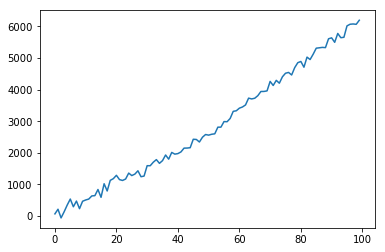

In [5]:
test1 = single_cpt_fastversion(100,50,75,100,1)
plt.plot(test1.time,test1.nucleotides)

In [6]:
def singlecpt_dataset(event_duration = 100, rate_1 = 50, noise_sigma = 100, ntraj = 10000):
    
    for i in range(50,250,10):
        ratechange = i
        data = single_cpt_fastversion(event_duration,
             rate_1,
              ratechange,
              noise_sigma,
              ntraj)
        data.to_csv(str(ratechange)+'.csv', index=False, columns=['time', 'nucleotides', 'trajectory', 'position'])       
    return 0;

In [7]:
singlecpt_dataset()

0

In [8]:
def singlecpt_dataset_variablelength(event_duration = 100, rate_1 = 50, noise_sigma = 100, ntraj = 10000):
    
    for i in range(6,42,2):
        event_duration = i
        data = single_cpt_fastversion(event_duration,
             rate_1,
              100,
              noise_sigma,
              ntraj)
        data.to_csv(str(event_duration)+'_length.csv', index=False, columns=['time', 'nucleotides', 'trajectory', 'position'])       
    return 0;

In [9]:
singlecpt_dataset_variablelength()

0

## Julia 0.6 Kernel - Change Point Analysis

Now switich to the Julia 0.6 kernel, import the change point functions and run change point analysis.

In [1]:
include("../src/KineticChangepoints.jl")

getchangepoints (generic function with 3 methods)

In [2]:
for i in collect(50:10:240)
    sourcefile = string(i, ".csv")
    outputfile = string("segs_", i, ".csv")
    getchangepoints(sourcefile, outputfile, 100, 0.99, ',', [1, 2, 3]);
end

In [3]:
for i in collect(6:2:40)
    sourcefile = string(i, "_length.csv")
    outputfile = string("segs_", i, ".csv")
    getchangepoints(sourcefile, outputfile, 100, 0.99, ',', [1, 2, 3]);
end

## R Kernel - Analysis and Plotting

Now switch to an R kernel, import necessary libraries and analyse the data for varying <i>R</i><sub>change</sub>.

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(svglite)))

### Varying <i>R</i><sub>change</sub>

In [2]:
cptlist = c()
for (i in seq(50,240,10)){
    cptlist = append(cptlist, paste0("segs_", i,".csv"))
    }

In [3]:
listy <- list()
for (i in 1:length(cptlist)){
    tmp <-  suppressWarnings(suppressMessages(read_csv(cptlist[i])))
    tmp <- tmp %>%
        group_by(trajectory) %>%
        mutate(ncpt = n() - 1)
    listy[[i]] <- tmp
    }

In [4]:
ratechangelist = list()
for (i in 1:length(listy)){ratechangelist[[i]] = ((1.0 + (i-1)/5.0)*50 - 50)/100}
ratechangelist = unlist(ratechangelist)

In [5]:
locationlist <- list()
sdlist <- list()
for (i in 1:length(listy)){
    framy <- listy[[i]] %>% filter(x2 != 99)
    sdvals <- framy %>% ungroup %>% summarise(meanx2 = mean(x2), sdx2 = sd(x2))
    locationlist <- append(locationlist, sdvals$meanx2)
    sdlist <- append(sdlist, sdvals$sdx2)
    }
locationaccuracy <- data.frame(location = unlist(locationlist) - 49.5, stdev = unlist(sdlist), ratechange = ratechangelist)
locationaccuracy <- locationaccuracy %>% filter(ratechange != 0)

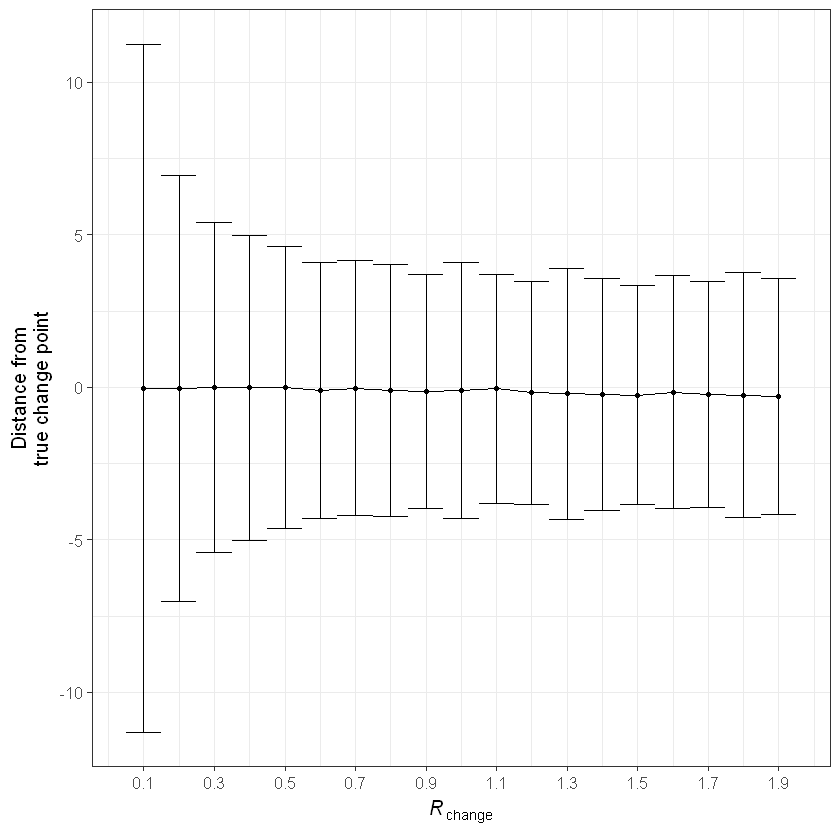

In [6]:
#Bonus figure:
rchange =  expression(italic(R)*{}[change])
accuracyplot <- ggplot(locationaccuracy, aes(x = ratechange, y = location))+
    geom_line(size = 0.5)+
    geom_point(size = 1)+
    geom_errorbar(aes(ymin=location-stdev, ymax=location+stdev), width=.1) +
    theme_bw(12)+
    labs(x = rchange, y = "Distance from\ntrue change point")+
    scale_x_continuous(labels = seq(0.1,10,0.2), breaks = seq(0.1,10,0.2))
accuracyplot
#ggsave("accuracyplot.png", accuracyplot, dpi = 600)

In [7]:
positions_accuracy <- list()
rchangelist <- list()
for (i in 2:length(listy)){ #For clarity used only every 4th member of listy in published version
    testtraj = listy[[i]]
    posvals <- testtraj %>%
        filter(x2 != 99) %>%
        mutate(rchange = ((1.0 + (i-1)/5.0)*50 - 50)/100)
    positions_accuracy <- append(positions_accuracy, posvals$x2)
    rchangelist <- append(rchangelist, posvals$rchange)
}

bing <- unlist(positions_accuracy)
rchanges <- unlist(rchangelist)
cphist <- data.frame(bing, rchanges)

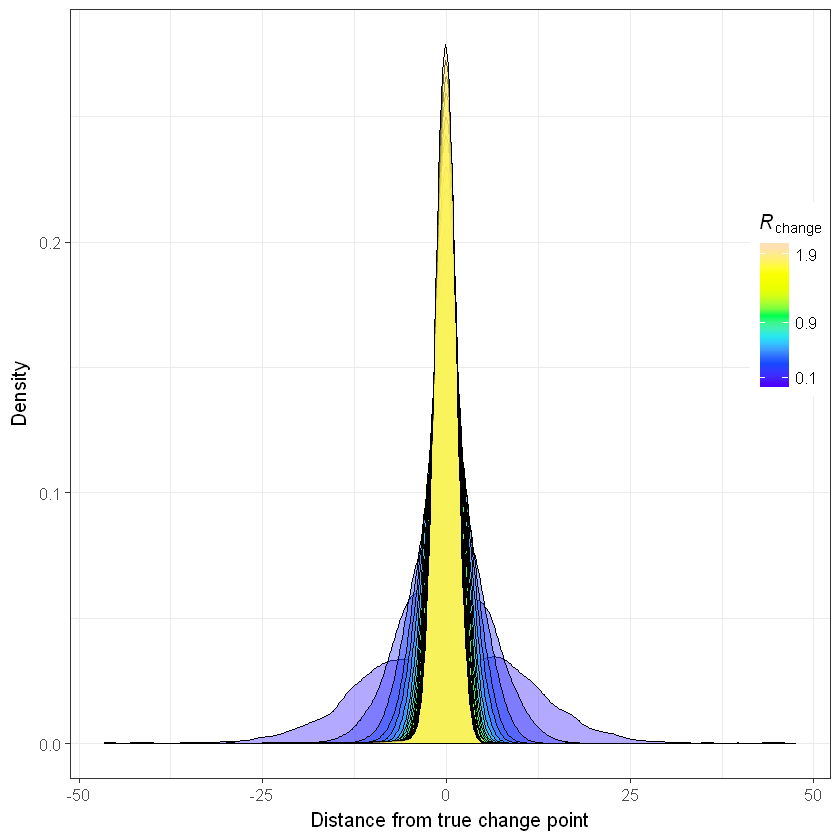

In [8]:
bighist <- ggplot(cphist, aes(x = bing - 49.5, group = factor(rchanges), fill = rchanges))+
geom_density(alpha = 0.4,bw = 1)+
theme_bw(12)+
labs(x = "Distance from true change point", y = "Density")+
scale_fill_gradientn(rchange, colours=topo.colors(7),na.value = "transparent",
                           breaks=c(0.1,0.9,1.9),labels=c(0.1,0.9,1.9),
                           limits=c(0,2))+
theme(legend.position=c(1,0.75),legend.justification = c(1, 1))
bighist
#ggsave("bighist.png", bighist, dpi = 600)

In [9]:
svglite(file = "bighist.svg", width = 3.3, height = 3)
bighist
dev.off()

png 
  2

### Plot example trajectories

In [10]:
lowrchange <- read.csv("60.csv")
mediumrchange <- read.csv("100.csv")
highrchange <- read.csv("200.csv")

In [11]:
examplelow <- lowrchange %>% filter(trajectory == 1)
examplemedium <- mediumrchange %>% filter(trajectory == 1)
examplehigh <- highrchange %>% filter(trajectory == 1)
rm(lowrchange, mediumrchange, highrchange)

In [12]:
outputlow <- listy[[2]] %>% filter(trajectory == 1)
outputmedium <- listy[[6]] %>% filter(trajectory == 1)
outputhigh <- listy[[16]] %>% filter(trajectory == 1)

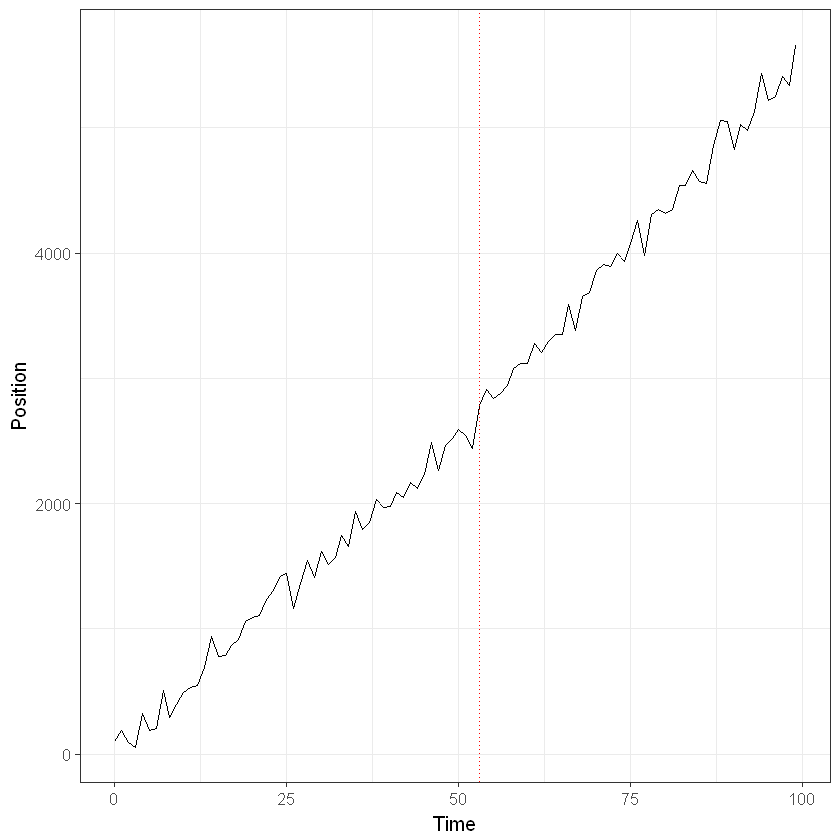

In [13]:
examplelowplot <- ggplot(examplelow, aes(x = time))+
geom_line(size = 0.5, aes(y = nucleotides))+
#geom_line(size = 0.5, aes(y = position), colour = "blue")+
theme_bw(12)+
scale_y_continuous(position = "left")+
geom_vline(xintercept = outputlow$x2[1], linetype = "dotted", colour = "red")+
labs(x = "Time", y = "Position")
examplelowplot

In [14]:
svglite(file = "examplelowplot.svg", width = 3.3, height = 3)
examplelowplot
dev.off()

png 
  2

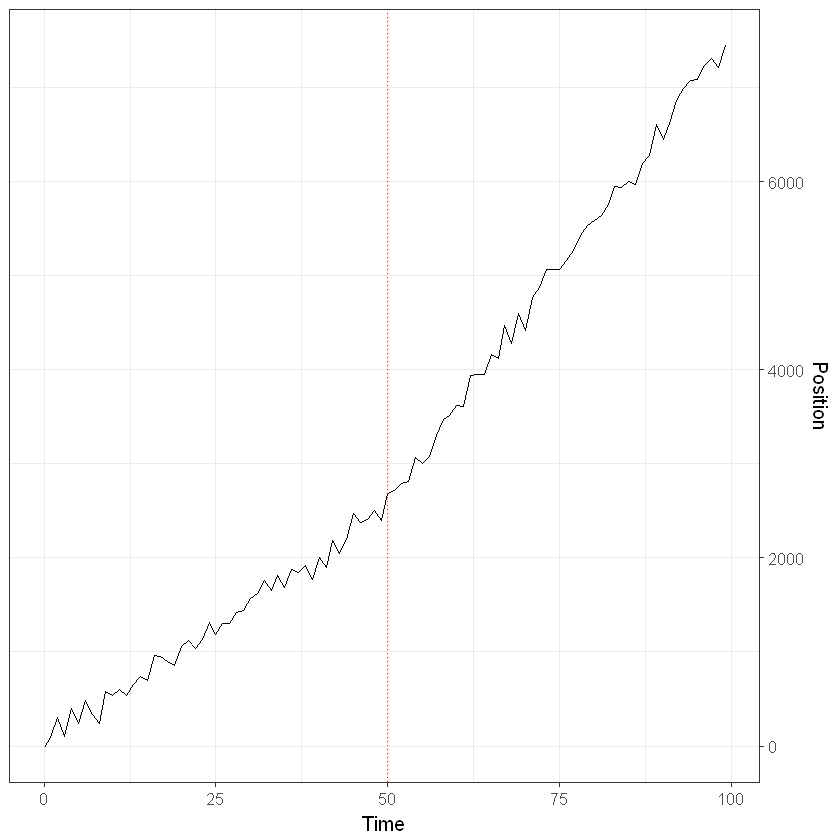

In [15]:
examplemediumplot <- ggplot(examplemedium, aes(x = time))+
geom_line(size = 0.5, aes(y = nucleotides))+
#geom_line(size = 0.5, aes(y = position), colour = "blue")+
theme_bw(12)+
scale_y_continuous(position = "right")+
geom_vline(xintercept = outputmedium$x2[1], linetype = "dotted", colour = "red")+
labs(x = "Time", y = "Position")
examplemediumplot

In [16]:
svglite(file = "examplemediumplot.svg", width = 3.3, height = 3)
examplemediumplot
dev.off()

png 
  2

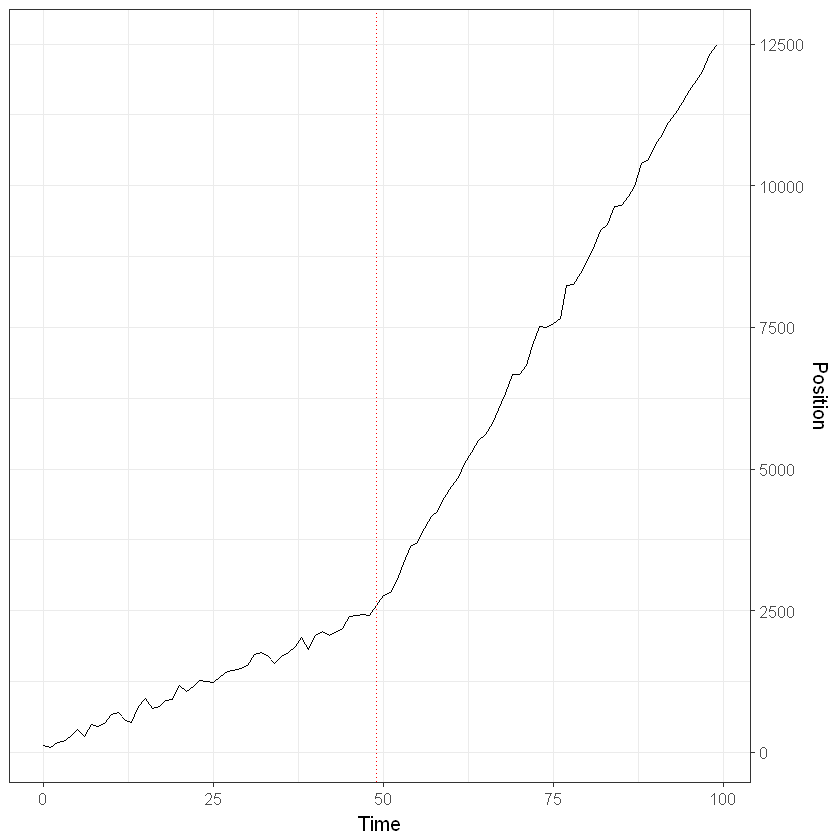

In [17]:
examplehighplot <- ggplot(examplehigh, aes(x = time))+
geom_line(size = 0.5, aes(y = nucleotides))+
#geom_line(size = 0.5, aes(y = position), colour = "blue")+
theme_bw(12)+
scale_y_continuous(position = "right")+
geom_vline(xintercept = outputhigh$x2[1], linetype = "dotted", colour = "red")+
labs(x = "Time", y = "Position")
examplehighplot

In [18]:
svglite(file = "examplehighplot.svg", width = 3.3, height = 3)
examplehighplot
dev.off()

png 
  2

### Varying Length

Run change point analysis and save the output files as segs_i.csv, where i is the trajectory length.

In [19]:
cptlist2 = c()
for (i in seq(6,40,2)){
    cptlist2 = append(cptlist2, paste0("segs_", i,".csv"))
    }

In [20]:
listy2 <- list()
for (i in 1:length(cptlist2)){
    tmp <-  suppressWarnings(suppressMessages(read_csv(cptlist2[i])))
    tmp <- tmp %>%
        group_by(trajectory) %>%
        mutate(ncpt = n() - 1)
    listy2[[i]] <- tmp
    }

In [21]:
cpcount <- list()
for (i in 1:length(listy2)){
    tmp <- listy2[[i]] %>% filter(x2 != i - 1)
   cpcount <- append(cpcount, mean(tmp$ncpt))
}
cpframe <- data.frame(cpcount = unlist(cpcount), lengthlist = seq(6,40,2))

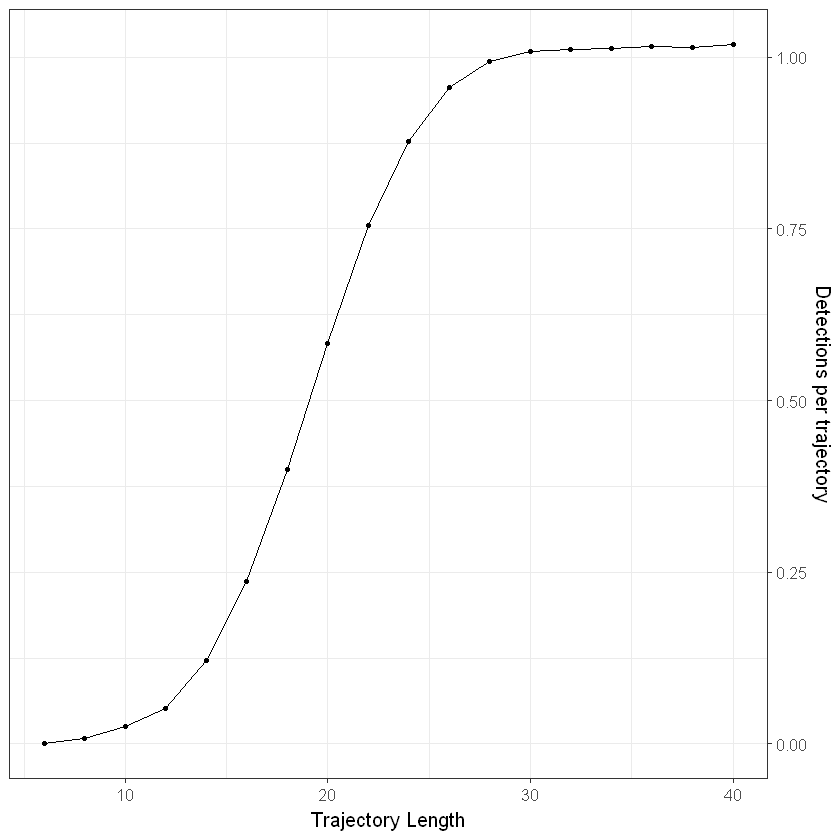

In [22]:
ncptplot <- ggplot(cpframe, aes(x = lengthlist, y= cpcount))+
geom_point(size = 1)+
geom_line(size = 0.5)+
theme_bw(12)+
labs(x = "Trajectory Length", y = "Detections per trajectory")+
scale_y_continuous(position = "right")
ncptplot
#ggsave("ncptplot.png", ncptplot, dpi = 600)

In [23]:
svglite(file = "ncptplot.svg", width = 3.3, height = 3)
ncptplot
dev.off()

png 
  2